# Data Pipeline

**Feature Extraction**

1.  **Capture Historical Delay Patterns:**
    * **Feature:** `Delay_Trend`
    * **Goal:** Identify recurring delays between specific airport pairs during particular weeks.
    * **Implementation:** Aggregate weekly delay data, focusing on the top 15 airports to manage memory and ensure generalizability.
    * **Rationale:** Historical delay patterns are strong indicators of future delays.

2.  **Assess Aircraft Reuse:**
    * **Feature:** `Same_Day_Tail_Reuse`
    * **Goal:** Determine if an aircraft is scheduled for multiple flights on the same day.
    * **Rationale:** High reuse can lead to delay propagation.

#### Drop 
- is_Holidays

Because so much data is missing, it is reasonable to remove 
Originally_Scheduled_Code_Share_Airline
DOT_ID_Originally_Scheduled_Code_Share_Airline
IATA_Code_Originally_Scheduled_Code_Share_Airline
Flight_Num_Originally_Scheduled_Code_Share_Airline
Unnamed: 119
precipitation_probability
precipitation_probability_dest_dep_time

# also not gonna need
'Origin_Lon', 'Origin_Lat',
'Dest_Lat', 'Dest_Lon', 'Duplicate', 'Origin', 'Dest', 'OriginAirportSeqID', 'OriginStateName', 'DestAirportSeqID', 'DestStateName', 'DestWac', 'OriginWac','Operated_or_Branded_Code_Share_Partners',
'OriginCityName', 'DestCityName', 'DestState', 'OriginState', 'DepTimeBlk', 'ArrTimeBlk', 'DistanceGroup', 'Aircraft_Airline', 'Aircraft_ModelCode', 'Aircraft_Type',
'IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline', 'latitude_dest_dep_time', 'longitude_dest_dep_time', 'longitude', 'latitude', 'Marketing_Airline_Network', 
'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline ', dest_dep_datetime, 'Flights'

because they are redundant

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import time
from sklearn.model_selection import cross_val_score

from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report


In [2]:
def stratified_random_split(df: pd.DataFrame, target_column: str, test_size: float = 0.1, random_state: int = 42):
    """
    Performs a stratified random train-test split to ensure all classes in 
    'Flight_Status' are proportionally represented in both sets.

    Parameters:
    df (pd.DataFrame): The dataset containing the target variable.
    target_column (str): The column representing the classification target.
    test_size (float): The proportion of data to be used as test data.
    random_state (int): Random seed for reproducibility.

    Returns:
    tuple: (train_df, test_df) DataFrames.
    """
    train_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df[target_column], random_state=random_state
    )

    print(f"Train size: {len(train_df)} samples")
    print(f"Test size: {len(test_df)} samples")

    return train_df, test_df



In [3]:
# Setting up the DataFrame for the flight data
flight_data = pd.read_parquet("WEATHER121.parquet")


In [4]:
# Stratify the data
train_data, test_data= stratified_random_split(flight_data, target_column="Flight_Status")

Train size: 13184010 samples
Test size: 1464890 samples


In [6]:
#downsample to 100000

train_data = train_data.sample(n=100000, random_state=42)

In [7]:
X_train = train_data.drop(columns=["Flight_Status"])
y_train = train_data["Flight_Status"]

In [8]:
y_train.value_counts()

Flight_Status
On-Time                             78470
Minor Delay - LateAircraftDelay      4238
Unknown                              3977
Minor Delay - CarrierDelay           3539
Medium Delay - LateAircraftDelay     2886
Medium Delay - CarrierDelay          1881
Minor Delay - NASDelay               1060
Weather Cancellation                  781
Major Delay - LateAircraftDelay       649
Major Delay - CarrierDelay            514
Medium Delay - NASDelay               487
Carrier Cancellation                  424
Minor Delay - WeatherDelay            326
Medium Delay - WeatherDelay           325
NAS Cancellation                      205
Major Delay - WeatherDelay             96
Major Delay - NASDelay                 91
Security Issue                         51
Name: count, dtype: int64

### Pipeline Functions

In [9]:
class ProgressLogger(BaseEstimator, TransformerMixin):
    """
    A transformer that logs progress through a pipeline.
    """
    
    def __init__(self, total_rows, log_interval=0.01, name='Pipeline'):
        self.total_rows = total_rows
        self.log_interval = log_interval
        self.name = name
        self.start_time = None
        self.last_log_percent = -1
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.start_time is None:
            self.start_time = time.time()
            print(f"{self.name} processing started on {self.total_rows:,} rows")
        
        current_rows = X.shape[0]
        percent_complete = current_rows / self.total_rows
        
        int_percent = int(percent_complete / self.log_interval)
        if int_percent > self.last_log_percent:
            self.last_log_percent = int_percent
            elapsed = time.time() - self.start_time
            
            percent_done = percent_complete * 100
            if percent_complete > 0:
                total_est = elapsed / percent_complete
                remaining = total_est - elapsed
                time_str = f" - Est. remaining: {remaining:.1f}s"
            else:
                time_str = ""
                
            print(f"{self.name}: {percent_done:.1f}% complete ({current_rows:,}/{self.total_rows:,} rows){time_str}")
        
        return X

class DelayTrendEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that precomputes a route-based delay trend using week_of_year and top N airports.

    Parameters:
        date_col (str): Name of the datetime column
        origin_col (str): Origin airport column
        dest_col (str): Destination airport column
        status_col (str): Flight status column for delay signal
        output_col (str): Name of the new delay trend feature
        top_n_airports (int): Number of top airports to retain by frequency
    """
    def __init__(self,
                 date_col='dep_datetime',
                 origin_col='OriginAirportID',
                 dest_col='DestAirportID',
                 status_col='Flight_Status',
                 output_col='Delay_Trend',
                 top_n_airports=15):
        self.date_col = date_col
        self.origin_col = origin_col
        self.dest_col = dest_col
        self.status_col = status_col
        self.output_col = output_col
        self.top_n_airports = top_n_airports

    def fit(self, X, y=None):
        X_temp = X.copy()
        X_temp[self.date_col] = pd.to_datetime(X_temp[self.date_col])
        X_temp['week_of_year'] = X_temp[self.date_col].dt.isocalendar().week

        X_temp['Flight_Status'] = y.reset_index(drop=True)
        
        # Restrict to top N airports
        all_airports = pd.concat([X_temp[self.origin_col], X_temp[self.dest_col]])
        top_airports = all_airports.value_counts().head(self.top_n_airports).index
        X_temp = X_temp[
            X_temp[self.origin_col].isin(top_airports) &
            X_temp[self.dest_col].isin(top_airports)
        ]

        # Create delay signal
        delay_reasons = [
            'CarrierDelay', 'WeatherDelay', 'NASDelay',
            'SecurityDelay', 'LateAircraftDelay'
        ]
        X_temp['delay_signal'] = 0
        mask = X_temp['Flight_Status'].str.contains('Delay', na=False)
        delay_type = X_temp.loc[mask, 'Flight_Status'].str.split(' - ').str[-1]
        valid = delay_type.isin(delay_reasons)
        X_temp.loc[mask[mask].index[valid], 'delay_signal'] = 1

        # Group by week and airport pair
        self.trend_lookup_ = (
            X_temp.groupby(['week_of_year', self.origin_col, self.dest_col])['delay_signal']
            .mean()
            .reset_index()
            .rename(columns={'delay_signal': self.output_col})
        )

        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_col] = pd.to_datetime(X[self.date_col])
        X['week_of_year'] = X[self.date_col].dt.isocalendar().week

        X = X.merge(
            self.trend_lookup_,
            on=['week_of_year', self.origin_col, self.dest_col],
            how='left'
        )

        X[self.output_col] = X[self.output_col].fillna(0)
        return X.drop(columns=['week_of_year'])

class SameDayTailReuseEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that creates a feature counting how many times
    the same tail number (aircraft) is used on the same day.

    Parameters:
        datetime_col (str): Column containing full departure datetime
        tail_col (str): Column name for tail number
        output_col (str): Name of the output column
    """

    def __init__(self,
                 datetime_col='dep_datetime',
                 tail_col='Tail_Number',
                 output_col='Same_Day_Tail_Reuse'):
        self.datetime_col = datetime_col
        self.tail_col = tail_col
        self.output_col = output_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])

        X['dep_date'] = X[self.datetime_col].dt.date

        X[self.output_col] = (
            X.groupby([self.tail_col, 'dep_date'])[self.tail_col]
            .transform('count')
            .astype(float)  
        )

        return X.drop(columns=['dep_date'])

    
class TurnaroundDelayEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that computes:
    - Previous_Flight_Delay: scheduled departure time of previous flight with same tail number on same day
    - Turnaround_Time: time between previous arrival and current departure

    Parameters:
        datetime_col (str): Column with full departure datetime
        dep_time_col (str): Column with scheduled departure time (e.g. CRSDepTime)
        arr_time_col (str): Column with scheduled arrival time (e.g. CRSArrTime)
        tail_col (str): Tail number column
        output_prefix (str): Prefix to use for new feature columns
    """

    def __init__(self,
                 datetime_col='dep_datetime',
                 dep_time_col='CRSDepTime',
                 arr_time_col='CRSArrTime',
                 tail_col='Tail_Number',
                 output_prefix=''):
        self.datetime_col = datetime_col
        self.dep_time_col = dep_time_col
        self.arr_time_col = arr_time_col
        self.tail_col = tail_col
        self.output_prefix = output_prefix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])
        X['dep_date'] = X[self.datetime_col].dt.date

        X = X.sort_values(by=[self.tail_col, 'dep_date', self.dep_time_col])

        prev_delay_col = self.output_prefix + 'Previous_Flight_Delay'
        turnaround_col = self.output_prefix + 'Turnaround_Time'

        X[prev_delay_col] = (
            X.groupby([self.tail_col, 'dep_date'])[self.dep_time_col]
            .shift(1)
        )

        X['Previous_Arrival_Time'] = (
            X.groupby([self.tail_col, 'dep_date'])[self.arr_time_col]
            .shift(1)
        )

        X[turnaround_col] = self._calculate_turnaround(X[self.dep_time_col], X['Previous_Arrival_Time'])

        X[prev_delay_col] = X[prev_delay_col].fillna(0)
        X[turnaround_col] = X[turnaround_col].fillna(0)

        return X.drop(columns=['dep_date', 'Previous_Arrival_Time'])

    def _calculate_turnaround(self, current_dep, previous_arr):
        """
        Applies time difference logic with wrap-around at midnight (2400).
        """
        diff = current_dep - previous_arr
        adjusted = diff.mask((~diff.isna()) & (diff < 0), diff + 2400)
        return adjusted

class SlackTimeEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that calculates slack time as the difference between scheduled
    arrival time (CRSArrTime) and scheduled elapsed time (CRSElapsedTime).

    Parameters:
        arr_col (str): Column name for scheduled arrival time.
        elapsed_col (str): Column name for scheduled elapsed time.
        output_col (str): Name of the output column to store slack time.
    """

    def __init__(self,
                 arr_col='CRSArrTime',
                 elapsed_col='CRSElapsedTime',
                 output_col='Slack_Time'):
        self.arr_col = arr_col
        self.elapsed_col = elapsed_col
        self.output_col = output_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.output_col] = X[self.arr_col] - X[self.elapsed_col]
        return X
    
    

class AgeClipper(BaseEstimator, TransformerMixin):
    """
    Transformer that caps aircraft age at a maximum value.
    
    Parameters:
    -----------
    max_age : float, default=56.9
        Maximum value for aircraft age
    column_name : str, default='Aircraft_Age'
        Name of the column to apply the cap to
    """
    
    def __init__(self, max_age=56.9, column_name='Aircraft_Age'):
        self.max_age = max_age
        self.column_name = column_name
    
    def fit(self, X, y=None):
        # Nothing to fit, just return self
        return self
    
    def transform(self, X):
        # Convert to DataFrame if it's not already
        X_transformed = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        # Apply the cap only if the column exists
        if self.column_name in X_transformed.columns:
            X_transformed[self.column_name] = np.minimum(X_transformed[self.column_name], self.max_age)
        
        # Return array if input was array
        if not isinstance(X, pd.DataFrame):
            X_transformed = X_transformed.values
            
        return X_transformed

### Pipeline Model

**Feature Extraction**

1.  **Capture Historical Delay Patterns:**
    * **New Feature:** `Delay_Trend`
    * **Goal:** Identify recurring delays between specific airport pairs during particular weeks.
    * **Implementation:** Aggregate weekly delay data, focusing on the top 15 airports to manage memory and ensure generalizability.
    * **Why we thought of this:** Historical delay patterns are strong indicators of future delays.

2.  **Assess Aircraft Reuse:**
    * **New Feature:** `Same_Day_Tail_Reuse`
    * **Goal:** Determine if an aircraft is scheduled for multiple flights on the same day.
    * **Why we thought of this:** High reuse can lead to delay propagation.

3.  **Calculate Turnaround Time:**
    * **New Feature:** `Turnaround_Time`
    * **Goal:** Measure the time between an aircraft's arrival and its next scheduled departure.
    * **Why we thought of this:** Short turnaround times increase delay vulnerability.

4.  **Determine Slack Time:**
    * **New Feature:** `Slack_Time`
    * **Goal:** Calculate the difference between scheduled arrival and expected travel time.
    * **Why we thought of this:** Slack time indicates buffer capacity, which can absorb minor delays.

**Outlier**

1.  **Handle Extreme Aircraft Age Values:**
    * **Feature:** `Aircraft_Age`
    * **Issue:**  unrealistic age values (There are hundreds of ages in the thousands)
    * **Solution:** Clip outliers to the second highest value (56.9 years). (more reasonable)
    * **Why:** Prevent outliers from skewing model training.

**Transformation and Imputation**

1.  **Apply Logarithmic Transformation:**
    * **Features:** `Distance`, `Wind_Gust`
    * **Using:** log1p (In case theres 0 values)
    * **Why:** Hopefully improve the models performance

2.  **Impute Missing Values:**
    * **Strategy:** Mean imputation for numeric features, most frequent imputation for categorical features.
    * **Why:** Maintain data completeness with a simple and effective approach.

**Feature Pruning**

1.  **Remove Redundant Information:**
    * **Action:** Drop columns like city/state names, latitude/longitude, and detailed marketing airline data.
    * **Why:** Eliminate redundant information that doesn't contribute to prediction accuracy.

2.  **Discard Uninformative or Highly Missing Columns:**
    * **Action:** Remove columns with significant missing data or those that offer little predictive value.
    * **Why:** Reduce noise and improve model focus.

**Encoding and Categorical**

1.  **One-Hot Encoding with Cardinality Limits:**
    * **Features:** `OriginAirportID`, `DestAirportID`
    * **Encoding:** `OneHotEncoder` with `max_categories=51`.
    * **Why:** We made a max of 50 categories (technically 51) so we kept the top 50 out of 300 something columns. 300 columns would be too much.

2.  **Full One-Hot Encoding:**
    * **Features:** `DayOfWeek`, `Month`, `Operating_Airline`
    * **Encoding:** Complete one-hot encoding.
    * **Why:** Preserve category identity for time- and airline-sensitive predictions.

**Dimensionality Reduction**

- **Principal Component Analysis (PCA):**
    * **Technique:** `PCA(n_components=50)`
    * **Rationale:** Address multicollinearity and reduce dimensionality, especially with correlated weather and location data.
    * **Why:** Improved training efficiency and reduced overfitting.

In [10]:
# import random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


numerical_features = [
    'Distance', 'relative_humidity_2m', 'temperature_2m',
    'Aircraft_Age', 'temperature_2m_dest_dep_time',
    'snowfall', 'soil_moisture_0_to_1cm',
    'snowfall_dest_dep_time', 
    'et0_fao_evapotranspiration_dest_dep_time',
    'surface_pressure_dest_dep_time', 'pressure_msl_dest_dep_time',
    'wind_direction_10m_dest_dep_time', 'wind_gusts_10m_dest_dep_time', 'CRSElapsedTime', 'Slack_Time'
]

categorical_features = [
    'DayOfWeek', 'Month',
    'OriginAirportID',
    'DestAirportID', 'Is_Holiday_Week', 'Operating_Airline '
]

drop_features = [
            'Aircraft_Model', 'Aircraft_EngineType', 'Holiday',
            'dep_datetime', 'Tail_Number', 'temperature_120m_dest_dep_time', 
            'temperature_180m_dest_dep_time', 'temperature_80m_dest_dep_time', 'temperature_180m', 
            'temperature_120m', 'temperature_80m', 'wind_speed_80m', 'wind_speed_120m',
            'wind_speed_180m', 'wind_direction_80m', 'wind_direction_120m', 'wind_direction_180m',
            'wind_speed_80m_dest_dep_time', 'wind_speed_120m_dest_dep_time', 'wind_speed_180m_dest_dep_time',
            'wind_direction_80m_dest_dep_time', 'wind_direction_120m_dest_dep_time', 'wind_direction_180m_dest_dep_time', 
            'soil_temperature_0cm_dest_dep_time', 'soil_temperature_0cm', 'rain', 'rain_dest_dep_time', 'dew_point_2m_dest_dep_time', 
            'cloud_cover_mid', 'cloud_cover', 'cloud_cover_mid_dest_dep_time', 'cloud_cover_dest_dep_time', 'dew_point_2m', 
            'wind_speed_10m', 'wind_speed_10m_dest_dep_time', 'visibility_dest_dep_time', 'visibility', 'apparent_temperature', 
            'apparent_temperature_dest_dep_time', 'vapour_pressure_deficit', 'vapour_pressure_deficit_dest_dep_time', 'Flights',
            'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline', 'Aircraft_Engines', 'Aircraft_Seats', 'Is_Freighter',
            'relative_humidity_2m_dest_dep_time', 'precipitation', 'showers', 'snow_depth', 'et0_fao_evapotranspiration',
            'evapotranspiration', 'cloud_cover_high', 'cloud_cover_low', 'surface_pressure', 'weather_code', 'pressure_msl', 
            'wind_direction_10m', 'wind_gusts_10m', 'precipitation_dest_dep_time', 'showers_dest_dep_time', 'snow_depth_dest_dep_time',
            'soil_moisture_0_to_1cm_dest_dep_time', 'evapotranspiration_dest_dep_time', 'cloud_cover_high_dest_dep_time',
            'cloud_cover_low_dest_dep_time', 'weather_code_dest_dep_time', 'Operated_or_Branded_Code_Share_Partners', 'Year',
            'Quarter', 'Marketing_Airline_Network', 'DayofMonth', 'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 
            'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 
            'OriginStateName', 'OriginWac', 'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 
            'DestStateName', 'DestWac', 'CRSDepTime', 'DepTimeBlk', 'CRSArrTime', 'ArrTimeBlk', 'DistanceGroup', 'Duplicate', 
            'Aircraft_Airline', 'Aircraft_ModelCode', 'Aircraft_Type'
        ]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('age_clipper', AgeClipper(max_age=56.9, column_name='Aircraft_Age')),
    ('log1p_distance', ColumnTransformer([
        ('log', FunctionTransformer(np.log1p), ['Distance', 'wind_gusts_10m_dest_dep_time'])
    ], remainder='passthrough', verbose_feature_names_out=False)), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OHE', ColumnTransformer([
        ('top50', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=51), ['OriginAirportID', 'DestAirportID']),
        ('OHE' , OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['DayOfWeek', 'Month', 'Operating_Airline '])
    ]))
])

preprocessor = Pipeline([
    ('initial_logger', ProgressLogger(total_rows=13000000, name='Starting Pipeline')),
    
    ('delay_trend', DelayTrendEncoder(
        date_col='dep_datetime',
        origin_col='OriginAirportID',
        dest_col='DestAirportID',
        status_col='Flight_Status',
        output_col='Delay_Trend',
        top_n_airports=15
    )),
    
    ('trend_logger', ProgressLogger(total_rows=13000000, name='Delay Trend Complete')),
    
    ('tail_reuse', SameDayTailReuseEncoder(
        datetime_col='dep_datetime',
        tail_col='Tail_Number',
        output_col='Same_Day_Tail_Reuse'
    )),
    
    ('reuse_logger', ProgressLogger(total_rows=13000000, name='Tail Reuse Complete')),
    
    ('turnaround_delay', TurnaroundDelayEncoder(
        datetime_col='dep_datetime',
        dep_time_col='CRSDepTime',
        arr_time_col='CRSArrTime',
        tail_col='Tail_Number',
        output_prefix=''
    )),
    
    ('turnaround_logger', ProgressLogger(total_rows=13000000, name='Turnaround Delay Complete')),
    
    ('slack_time', SlackTimeEncoder(
        arr_col='CRSArrTime',
        elapsed_col='CRSElapsedTime',
        output_col='Slack_Time'
    )),
    
    ('slack_logger', ProgressLogger(total_rows=13000000, name='Slack Time Complete')),
    
    ('feature_prep', ColumnTransformer([
        ('numeric', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features),
        ('drop', 'drop', drop_features)
    ], remainder='passthrough', verbose_feature_names_out=False, n_jobs=16)),
    
    ('prep_logger', ProgressLogger(total_rows=13000000, name='Feature Prep Complete')),
    ('select', PCA(
        n_components=50,
        random_state=42,
    )),
    ('final_logger', ProgressLogger(total_rows=13000000, name='Pipeline Complete'))
])
# so that I dont forget, dep_datetime is dropped because of redundancy

preprocessor

Pipeline(steps=[('initial_logger',
                 ProgressLogger(name='Starting Pipeline', total_rows=13000000)),
                ('delay_trend', DelayTrendEncoder()),
                ('trend_logger',
                 ProgressLogger(name='Delay Trend Complete',
                                total_rows=13000000)),
                ('tail_reuse', SameDayTailReuseEncoder()),
                ('reuse_logger',
                 ProgressLogger(name='Tail Reuse Complete',
                                total_rows=13000000)),
                ('turnaround_delay', T...
                                                   'soil_temperature_0cm',
                                                   'rain', 'rain_dest_dep_time',
                                                   'dew_point_2m_dest_dep_time',
                                                   'cloud_cover_mid',
                                                   'cloud_cover', ...])],
                                   verbose_feature_names_out=False)),
                ('prep_logger',
                 ProgressLogger(name='Feature Prep Complete',
                                total_rows=13000000)),
                ('select', PCA(n_components=50, random_state=42)),
                ('final_logger',
                 ProgressLogger(name='Pipeline Complete',
                                total_rows=13000000))])

In [11]:
# Train the pipeline in this cell and run it on X, this cell must end with the transformed data
X = preprocessor.fit_transform(X_train, y_train)

pd.set_option('display.max_columns', None)
X

Starting Pipeline processing started on 13,000,000 rows
Starting Pipeline: 0.8% complete (100,000/13,000,000 rows) - Est. remaining: 0.0s
Delay Trend Complete processing started on 13,000,000 rows
Delay Trend Complete: 0.8% complete (100,000/13,000,000 rows) - Est. remaining: 0.0s
Tail Reuse Complete processing started on 13,000,000 rows
Tail Reuse Complete: 0.8% complete (100,000/13,000,000 rows) - Est. remaining: 0.0s
Turnaround Delay Complete processing started on 13,000,000 rows
Turnaround Delay Complete: 0.8% complete (100,000/13,000,000 rows) - Est. remaining: 0.0s
Slack Time Complete processing started on 13,000,000 rows
Slack Time Complete: 0.8% complete (100,000/13,000,000 rows) - Est. remaining: 0.0s
Feature Prep Complete processing started on 13,000,000 rows
Feature Prep Complete: 0.8% complete (100,000/13,000,000 rows) - Est. remaining: 0.0s
Pipeline Complete processing started on 13,000,000 rows
Pipeline Complete: 0.8% complete (100,000/13,000,000 rows) - Est. remaining: 0

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49
84341,-16.422066,0.629735,-0.577326,0.763254,-0.525510,-0.217942,-0.030102,-0.086484,-0.362119,0.188034,0.451343,1.617902,-0.253634,1.039894,0.149846,-0.712233,-0.107708,-0.231456,0.122008,-0.294628,0.021570,0.094865,0.191816,0.501837,-1.026513,-0.284591,-0.768741,-0.462662,-0.014789,-0.095917,-0.181793,-0.309857,-0.666988,0.297275,0.119855,-0.368747,-0.381657,0.170739,0.035518,-0.008964,0.030369,-0.003904,-0.170526,-0.079016,0.055584,0.057529,-0.127042,-0.028670,0.035823,-0.039063
37492,-16.420893,0.629228,0.501706,-0.604750,-1.318426,1.131188,0.199979,0.217391,-0.367736,-0.294440,-0.864229,-0.075810,0.970314,0.398809,-0.316464,-0.370934,-0.625885,-0.196578,0.682000,0.417343,-0.288286,-0.247976,-0.248912,-0.166117,-0.224236,-0.113447,-0.279638,-0.370985,0.040746,0.430765,0.691947,0.226559,-0.182041,-0.098965,-0.076932,-0.099054,-0.171451,0.113227,0.085405,-0.153919,-0.013129,-0.045527,-0.034792,-0.004957,-0.021386,0.075703,0.001526,-0.073745,-0.007049,0.045926
55696,-16.421565,0.629446,0.591951,0.316283,-1.264859,-0.442453,-0.028362,-0.679764,0.125686,0.178244,0.949067,1.127872,-0.202599,1.002088,-0.759129,-0.160709,-1.021258,-0.285528,0.054895,-0.253997,0.099348,0.747397,-0.515317,-0.133758,-0.058576,-0.132494,-0.246783,-0.509328,0.039597,-0.126155,-0.426392,0.658321,-0.184967,-0.121276,-0.035441,0.055026,-0.062399,0.194585,0.166251,-0.117087,-0.036545,-0.342818,0.058858,0.038937,-0.307284,-0.351493,0.251523,0.172914,0.411106,-0.174861
8859,-16.421128,0.628856,1.844510,0.691778,0.601537,0.645684,0.359164,0.688883,-0.375633,0.103163,-0.434548,0.263910,-0.086369,-0.105354,-0.756412,0.213743,-0.068561,-0.398659,-0.347328,-0.479016,-0.638318,-0.238547,-0.371411,-0.266563,-0.721120,-0.195646,-0.650569,-0.474195,-0.506688,0.671810,-0.368687,-0.191368,0.015168,-0.147630,0.008416,-0.275797,0.113454,-0.227764,-0.161147,-0.035120,0.016266,-0.059114,-0.145998,-0.065076,0.016642,0.117759,-0.111052,-0.053375,0.011599,0.035323
63927,-16.421810,0.629462,-0.126997,0.709289,0.257867,-0.807879,0.101086,-0.596242,0.269087,0.307274,1.011550,0.275414,-0.113109,1.026615,0.423229,-0.141608,-0.699814,-0.251352,0.751094,0.351820,-0.239736,-0.224332,-0.283115,-0.155056,-0.301509,-0.172323,-0.339900,-0.412803,-0.430122,0.687481,-0.347457,-0.164679,0.003533,-0.055043,0.051793,-0.062969,0.010715,-0.218209,-0.096490,-0.174773,-0.001010,-0.001306,-0.071331,-0.017383,0.020002,0.030511,-0.003155,-0.109200,-0.002976,0.003425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56457,-16.422053,0.629549,-1.450716,0.623646,0.062982,-2.363688,0.693986,-0.316988,-0.134607,0.416520,0.556477,1.445695,-0.312841,0.818153,0.218563,-0.968571,-0.060627,-0.238945,-0.337368,-0.547027,-0.665425,-0.257470,-0.385455,-0.269371,-0.729074,-0.140120,-0.722310,-0.380219,0.056590,-0.097358,0.027195,0.163866,-0.117983,-0.153332,-0.642769,-0.230871,-0.214790,-0.493012,-0.341832,0.014578,0.008642,-0.050687,-0.148377,-0.064493,0.080049,0.033372,-0.077691,-0.021468,0.086555,-0.033700
85107,-16.421275,0.628816,-0.620013,-0.749763,1.456000,-0.189871,0.886372,0.539797,-0.199894,-0.119078,-0.600363,-0.141853,0.329378,-0.550366,-0.279915,0.557945,0.813338,-0.119814,0.098901,-0.195216,0.007670,0.075167,0.034473,-0.033531,-0.436680,0.904475,-0.008134,-0.092986,0.048189,-0.077794,0.045176,0.213958,-0.135196,-0.122675,-0.575374,-0.037814,-0.232981,-0.318858,-0.272581,-0.031569,0.050013,0.130815,-0.210443,0.076466,0.014197,-0.026374,-0.201623,0.052532,-0.028573,0.013184
606,-16.419983,0.630109,-0.975842,-0.914575,1.733151,-0.001987,-0.608556,0.276753,-0.065842,

In [19]:
# Save the preprocessor as a parquet file
#X.to_parquet("preprocessor.parquet")


In [20]:
# pickle the preprocessor
import pickle
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
**Feature Extraction**

1.  **Capture Historical Delay Patterns:**
    * **New Feature:** `Delay_Trend`
    * **Goal:** Identify recurring delays between specific airport pairs during particular weeks.
    * **Implementation:** Aggregate weekly delay data, focusing on the top 15 airports to manage memory and ensure generalizability.
    * **Why we thought of this:** Historical delay patterns are strong indicators of future delays.

2.  **Assess Aircraft Reuse:**
    * **New Feature:** `Same_Day_Tail_Reuse`
    * **Goal:** Determine if an aircraft is scheduled for multiple flights on the same day.
    * **Why we thought of this:** High reuse can lead to delay propagation.

3.  **Calculate Turnaround Time:**
    * **New Feature:** `Turnaround_Time`
    * **Goal:** Measure the time between an aircraft's arrival and its next scheduled departure.
    * **Why we thought of this:** Short turnaround times increase delay vulnerability.

4.  **Determine Slack Time:**
    * **New Feature:** `Slack_Time`
    * **Goal:** Calculate the difference between scheduled arrival and expected travel time.
    * **Why we thought of this:** Slack time indicates buffer capacity, which can absorb minor delays.

**Outlier**

1.  **Handle Extreme Aircraft Age Values:**
    * **Feature:** `Aircraft_Age`
    * **Issue:**  unrealistic age values (There are hundreds of ages in the thousands)
    * **Solution:** Clip outliers to the second highest value (56.9 years). (more reasonable)
    * **Why:** Prevent outliers from skewing model training.

**Transformation and Imputation**

1.  **Apply Logarithmic Transformation:**
    * **Features:** `Distance`, `Wind_Gust`
    * **Using:** log1p (In case theres 0 values)
    * **Why:** Hopefully improve the models performance

2.  **Impute Missing Values:**
    * **Strategy:** Mean imputation for numeric features, most frequent imputation for categorical features.
    * **Why:** Maintain data completeness with a simple and effective approach.

**Feature Pruning**

1.  **Remove Redundant Information:**
    * **Action:** Drop columns like city/state names, latitude/longitude, and detailed marketing airline data.
    * **Why:** Eliminate redundant information that doesn't contribute to prediction accuracy.

2.  **Discard Uninformative or Highly Missing Columns:**
    * **Action:** Remove columns with significant missing data or those that offer little predictive value.
    * **Why:** Reduce noise and improve model focus.

**Encoding and Categorical**

1.  **One-Hot Encoding with Cardinality Limits:**
    * **Features:** `OriginAirportID`, `DestAirportID`
    * **Encoding:** `OneHotEncoder` with `max_categories=51`.
    * **Why:** We made a max of 50 categories (technically 51) so we kept the top 50 out of 300 something columns. 300 columns would be too much.

2.  **Full One-Hot Encoding:**
    * **Features:** `DayOfWeek`, `Month`, `Operating_Airline`
    * **Encoding:** Complete one-hot encoding.
    * **Why:** Preserve category identity for time- and airline-sensitive predictions.

**Dimensionality Reduction**

- **Principal Component Analysis (PCA):**
    * **Technique:** `PCA(n_components=50)`
    * **Rationale:** Address multicollinearity and reduce dimensionality, especially with correlated weather and location data.
    * **Why:** Improved training efficiency and reduced overfitting.

In [13]:
import sys

for name, step in preprocessor.named_steps.items():
    print(name, type(step), sys.getsizeof(step))

initial_logger <class '__main__.ProgressLogger'> 48
delay_trend <class '__main__.DelayTrendEncoder'> 48
trend_logger <class '__main__.ProgressLogger'> 48
tail_reuse <class '__main__.SameDayTailReuseEncoder'> 48
reuse_logger <class '__main__.ProgressLogger'> 48
turnaround_delay <class '__main__.TurnaroundDelayEncoder'> 48
turnaround_logger <class '__main__.ProgressLogger'> 48
slack_time <class '__main__.SlackTimeEncoder'> 48
slack_logger <class '__main__.ProgressLogger'> 48
feature_prep <class 'sklearn.compose._column_transformer.ColumnTransformer'> 48
prep_logger <class '__main__.ProgressLogger'> 48
select <class 'sklearn.feature_selection._from_model.SelectFromModel'> 48
final_logger <class '__main__.ProgressLogger'> 48


# Models

In [13]:
from sklearn.metrics import make_scorer, precision_score, recall_score, precision_recall_curve
def precision_at_recall(y, y_pred, *, recall, **kwargs):
    """
    Calculate the precision at a given recall level.

    To use this with cross_val_score, you need to use the make_scorer function to
    create a scoring function that can be used with cross_val_score. For example:

        scorer = make_scorer(precision_at_recall, recall=0.9)  # 0.9 is the minimum recall level
        cross_val_score(model, X, y, cv=5, scoring=scorer)

    The default will only work for binary classification problems. You must change the
    average parameter if you want to use for multiclass classification. For example:

        scorer = make_scorer(precision_at_recall, recall=0.9, average="micro")
    """
    return precision_score(y, y_pred, **kwargs) if recall_score(y, y_pred, **kwargs) > recall else 0.0

def recall_at_precision(y, y_pred, *, precision, **kwargs):
    """
    Calculate the recall at a given precision level.

    To use this with cross_val_score, you need to use the make_scorer function to
    create a scoring function that can be used with cross_val_score. For example:

        scorer = make_scorer(recall_at_precision, precision=0.9)
        cross_val_score(model, X, y, cv=5, scoring=scorer)

    The default will only work for binary classification problems. You must change the
    average parameter if you want to use for multiclass classification. For example:

        scorer = make_scorer(recall_at_precision, precision=0.9, average="micro")
    """
    return recall_score(y, y_pred, **kwargs) if precision_score(y, y_pred, **kwargs) > precision else 0.0

In [35]:
X_sample = X.sample(n=100000, random_state=42)
y_train = y_train.sample(n=100000, random_state=42)

## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=20,
    min_samples_leaf=10,
    class_weight='balanced'
)

scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

scores = cross_val_score(dt, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(dt, X_sample, y_train, cv=5, n_jobs=64)

# Calculate recall, precision, and F1 score
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Cross-validated performance
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))

print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   5 out of   5 | elapsed:   19.0s finished


Recall: 0.0520
Precision: 0.0549
F1 Score: 0.0131
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.00      0.14      0.01       424
      Major Delay - CarrierDelay       0.01      0.11      0.01       514
 Major Delay - LateAircraftDelay       0.01      0.12      0.01       649
          Major Delay - NASDelay       0.00      0.01      0.00        91
      Major Delay - WeatherDelay       0.00      0.06      0.00        96
     Medium Delay - CarrierDelay       0.02      0.06      0.03      1881
Medium Delay - LateAircraftDelay       0.03      0.02      0.03      2886
         Medium Delay - NASDelay       0.00      0.11      0.01       487
     Medium Delay - WeatherDelay       0.00      0.05      0.01       325
      Minor Delay - CarrierDelay       0.03      0.03      0.03      3539
 Minor Delay - LateAircraftDelay       0.04      0.02      0.02      4238
          Minor Delay

In [24]:
y_train.value_counts()

Flight_Status
On-Time                             78470
Minor Delay - LateAircraftDelay      4238
Unknown                              3977
Minor Delay - CarrierDelay           3539
Medium Delay - LateAircraftDelay     2886
Medium Delay - CarrierDelay          1881
Minor Delay - NASDelay               1060
Weather Cancellation                  781
Major Delay - LateAircraftDelay       649
Major Delay - CarrierDelay            514
Medium Delay - NASDelay               487
Carrier Cancellation                  424
Minor Delay - WeatherDelay            326
Medium Delay - WeatherDelay           325
NAS Cancellation                      205
Major Delay - WeatherDelay             96
Major Delay - NASDelay                 91
Security Issue                         51
Name: count, dtype: int64

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict

# Create Gradient Boosting classifier
model = GradientBoostingClassifier(
    n_estimators=20,    
    max_depth=3,        
    learning_rate=0.1,  
    subsample=0.6,       
    random_state=42,
    verbose=2            
)

# Create scorer for precision at recall
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Run cross-validation with the Gradient Boosting model
scores = cross_val_score(model, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(model, X_sample, y_train, cv=5, n_jobs=64)

# Calculate metrics
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Recall: 0.0556
Precision: 0.0482
F1 Score: 0.0494
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.03      0.00      0.00       424
      Major Delay - CarrierDelay       0.02      0.00      0.00       514
 Major Delay - LateAircraftDelay       0.00      0.00      0.00       649
          Major Delay - NASDelay       0.00      0.00      0.00        91
      Major Delay - WeatherDelay       0.00      0.00      0.00        96
     Medium Delay - CarrierDelay       0.00      0.00      0.00      1881
Medium Delay - LateAircraftDelay       0.00      0.00      0.00      2886
         Medium Delay - NASDelay       0.03      0.00      0.00       487
     Medium Delay - WeatherDelay       0.00      0.00      0.00       325
      Minor Delay - CarrierDelay       0.00      0.00      0.00      3539
 Minor Delay - LateAircraftDelay       0.00      0.00      0.00      4238
          Minor Delay

## SGD Regression

In [40]:
from sklearn.linear_model import SGDClassifier

# Basic SGD classifier for multi-class classification
sgd_classifier = SGDClassifier(
    loss='log_loss',     
    alpha=0.0001,   
    n_jobs=64,
    random_state=42       
)

# Create scorer for precision at recall
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Run cross-validation with the Gradient Boosting model
scores = cross_val_score(sgd_classifier, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(sgd_classifier, X_sample, y_train, cv=5, n_jobs=64)

# Calculate metrics
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anacond

Recall: 0.0555
Precision: 0.0436
F1 Score: 0.0488
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.00      0.00      0.00       424
      Major Delay - CarrierDelay       0.00      0.00      0.00       514
 Major Delay - LateAircraftDelay       0.00      0.00      0.00       649
          Major Delay - NASDelay       0.00      0.00      0.00        91
      Major Delay - WeatherDelay       0.00      0.00      0.00        96
     Medium Delay - CarrierDelay       0.00      0.00      0.00      1881
Medium Delay - LateAircraftDelay       0.00      0.00      0.00      2886
         Medium Delay - NASDelay       0.00      0.00      0.00       487
     Medium Delay - WeatherDelay       0.00      0.00      0.00       325
      Minor Delay - CarrierDelay       0.00      0.00      0.00      3539
 Minor Delay - LateAircraftDelay       0.00      0.00      0.00      4238
          Minor Delay

In [41]:
from sklearn.linear_model import LogisticRegression

# Fast but effective logistic regression configuration
log_reg = LogisticRegression(
    penalty='l2',
    C=1.0,                 
    max_iter=200,        
    tol=1e-3,           
    class_weight='balanced', 
    n_jobs=64,          
    random_state=42,     
    verbose=1            
)

# Run cross-validation with the Gradient Boosting model
scores = cross_val_score(log_reg, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(log_reg, X_sample, y_train, cv=5, n_jobs=64)

# Calculate metrics
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  4.52906D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  5.08173D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  5.06678D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  6.82702D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  2.30413D+05    |proj g|=  1.83678D+04

At iterate   50    f=  2.30460D+05    |proj g|=  7.64161D+03

At iterate   50    f=  2.30432D+05    |proj g|=  2.04515D+04

At iterate   50    f=  2.30363D+05    |proj g|=  3.13326D+04

At iterate   50    f=  2.30345D+05    |proj g|=  1.77993D+05

At iterate  100    f=  2.29901D+05    |proj g|=  6.31362D+04

At iterate  100    f=  2.29820D+05    |proj g|=  1.75573D+04

At iterate  100    f=  2.30006D+05    |proj g|=  7.56836D+04

At iterate  100    f=  2.29745D+05    |proj g|=  3.66572D+04

At iterate  100    f=  2.29718D+05    |proj g|=  9.28460D+04

At iterate  150    f=  2.28940D+05    |proj g|=  2.57050D+04

At iterate  150    f=  2.29335D+05    |proj g|=  4.78086D+04

At iterate  150    f=  2.29303D+05    |proj g|=  1.39796D+04

At iterate  150    f=  2.29740D+05    |proj g|=  2.78229D+04

At iterate  150    f=  2.29359D+05    |proj g|=  1.66245D+04

At iterate  200    f=  2.28725D+05    |proj g|=  8.22377D+04

       

/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   10.8s finished
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ


At iterate  200    f=  2.28091D+05    |proj g|=  5.04936D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  918    200    214      1     0     0   5.049D+04   2.281D+05
  F =   228091.21236615849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  200    f=  2.29113D+05    |proj g|=  3.50903D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj

/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo


At iterate  200    f=  2.28640D+05    |proj g|=  1.39139D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  918    200    217      1     0     0   1.391D+04   2.286D+05
  F =   228639.94628400612     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=64)]: Done   5 out of   5 | elapsed:   12.8s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent worker

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  5.08173D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  5.06678D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  4.50830D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          918     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31230D+05    |proj g|=  4.52906D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  2.30345D+05    |proj g|=  1.77993D+05

At iterate   50    f=  2.30432D+05    |proj g|=  2.04515D+04

At iterate   50    f=  2.30460D+05    |proj g|=  7.64161D+03

At iterate   50    f=  2.30413D+05    |proj g|=  1.83678D+04

At iterate   50    f=  2.30363D+05    |proj g|=  3.13326D+04

At iterate  100    f=  2.29718D+05    |proj g|=  9.28460D+04

At iterate  100    f=  2.29820D+05    |proj g|=  1.75573D+04

At iterate  100    f=  2.30006D+05    |proj g|=  7.56836D+04

At iterate  100    f=  2.29901D+05    |proj g|=  6.31362D+04

At iterate  100    f=  2.29745D+05    |proj g|=  3.66572D+04

At iterate  150    f=  2.29303D+05    |proj g|=  1.39796D+04

At iterate  150    f=  2.29359D+05    |proj g|=  1.66245D+04

At iterate  150    f=  2.29740D+05    |proj g|=  2.78229D+04

At iterate  150    f=  2.29335D+05    |proj g|=  4.78086D+04

At iterate  150    f=  2.28940D+05    |proj g|=  2.57050D+04

At iterate  200    f=  2.28655D+05    |proj g|=  1.18179D+04

       

/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   10.8s finished



At iterate  200    f=  2.29113D+05    |proj g|=  3.50903D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  918    200    213      1     0     0   3.509D+04   2.291D+05
  F =   229113.05220798624     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  200    f=  2.28640D+05    |proj g|=  1.39139D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj

/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   11.7s finished
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ


At iterate  200    f=  2.28725D+05    |proj g|=  8.22377D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  918    200    211      1     0     0   8.224D+04   2.287D+05
  F =   228724.81232402046     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   12.1s finished



At iterate  200    f=  2.28091D+05    |proj g|=  5.04936D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  918    200    214      1     0     0   5.049D+04   2.281D+05
  F =   228091.21236615849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   12.8s finished


Recall: 0.0682
Precision: 0.0681
F1 Score: 0.0058
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.00      0.04      0.01       424
      Major Delay - CarrierDelay       0.01      0.07      0.01       514
 Major Delay - LateAircraftDelay       0.00      0.00      0.00       649
          Major Delay - NASDelay       0.00      0.10      0.00        91
      Major Delay - WeatherDelay       0.00      0.27      0.00        96
     Medium Delay - CarrierDelay       0.04      0.00      0.01      1881
Medium Delay - LateAircraftDelay       0.04      0.01      0.01      2886
         Medium Delay - NASDelay       0.00      0.05      0.01       487
     Medium Delay - WeatherDelay       0.00      0.05      0.01       325
      Minor Delay - CarrierDelay       0.03      0.00      0.00      3539
 Minor Delay - LateAircraftDelay       0.04      0.00      0.00      4238
          Minor Delay

## MLP

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_score

# Create the MLP classifier with precision-focused parameters
mlp = MLPClassifier(
    hidden_layer_sizes=(100),
    max_iter=100,              
    early_stopping=True,
    random_state=42            
)

# Create scorer for precision at recall
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Run cross-validation with the Gradient Boosting model
scores = cross_val_score(mlp, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(mlp, X_sample, y_train, cv=5, n_jobs=64)

# Calculate metrics
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Recall: 0.0556
Precision: 0.0571
F1 Score: 0.0489
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.00      0.00      0.00       424
      Major Delay - CarrierDelay       0.00      0.00      0.00       514
 Major Delay - LateAircraftDelay       0.00      0.00      0.00       649
          Major Delay - NASDelay       0.00      0.00      0.00        91
      Major Delay - WeatherDelay       0.00      0.00      0.00        96
     Medium Delay - CarrierDelay       0.00      0.00      0.00      1881
Medium Delay - LateAircraftDelay       0.00      0.00      0.00      2886
         Medium Delay - NASDelay       0.00      0.00      0.00       487
     Medium Delay - WeatherDelay       0.00      0.00      0.00       325
      Minor Delay - CarrierDelay       0.00      0.00      0.00      3539
 Minor Delay - LateAircraftDelay       0.17      0.00      0.00      4238
          Minor Delay

## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,        
    max_depth=15,            
    min_samples_split=10,    
    min_samples_leaf=5,     
    max_features='sqrt',     
    bootstrap=True,          
    class_weight='balanced', 
    n_jobs=64,              
    random_state=42,         
    verbose=1               
)

# Create scorer for precision at recall
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Run cross-validation with the Gradient Boosting model
scores = cross_val_score(rf, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(rf, X_sample, y_train, cv=5, n_jobs=64)

# Calculate metrics
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    7.6s remaining:    2.7s
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    7.6s remaining:    2.7s
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    7.7s remaining:    2.7s
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    7.9s remaining:    2.8s
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    8.1s remaining:    2.8s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    8.4s finished
[Parallel(n_jobs=64)]: Using backend 

Recall: 0.0564
Precision: 0.0559
F1 Score: 0.0523
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.00      0.01      0.01       424
      Major Delay - CarrierDelay       0.01      0.01      0.01       514
 Major Delay - LateAircraftDelay       0.01      0.02      0.01       649
          Major Delay - NASDelay       0.00      0.00      0.00        91
      Major Delay - WeatherDelay       0.00      0.00      0.00        96
     Medium Delay - CarrierDelay       0.02      0.04      0.03      1881
Medium Delay - LateAircraftDelay       0.03      0.06      0.04      2886
         Medium Delay - NASDelay       0.01      0.02      0.01       487
     Medium Delay - WeatherDelay       0.00      0.01      0.01       325
      Minor Delay - CarrierDelay       0.04      0.07      0.05      3539
 Minor Delay - LateAircraftDelay       0.04      0.08      0.05      4238
          Minor Delay

In [44]:
# KNN configuration
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,   
    weights='distance', 
    n_jobs=64           
)


# Create scorer for precision at recall
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Run cross-validation with the Gradient Boosting model
scores = cross_val_score(knn, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(knn, X_sample, y_train, cv=5, n_jobs=64)

# Calculate metrics
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/external/python/anaconda3_cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Recall: 0.0560
Precision: 0.0589
F1 Score: 0.0513
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.00      0.00      0.00       424
      Major Delay - CarrierDelay       0.00      0.00      0.00       514
 Major Delay - LateAircraftDelay       0.00      0.00      0.00       649
          Major Delay - NASDelay       0.00      0.00      0.00        91
      Major Delay - WeatherDelay       0.10      0.01      0.02        96
     Medium Delay - CarrierDelay       0.02      0.00      0.00      1881
Medium Delay - LateAircraftDelay       0.02      0.00      0.00      2886
         Medium Delay - NASDelay       0.00      0.00      0.00       487
     Medium Delay - WeatherDelay       0.00      0.00      0.00       325
      Minor Delay - CarrierDelay       0.03      0.00      0.01      3539
 Minor Delay - LateAircraftDelay       0.05      0.01      0.01      4238
          Minor Delay

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    n_jobs=64,
    random_state=42
)

# Create scorer for precision at recall
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Run cross-validation with the Gradient Boosting model
scores = cross_val_score(extra_trees, X_sample, y_train, cv=5, scoring=scorer, verbose=1, n_jobs=64)

# Fit the model and predict using cross-validation
y_pred_cv = cross_val_predict(extra_trees, X_sample, y_train, cv=5, n_jobs=64)

# Calculate metrics
recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   5 out of   5 | elapsed:    4.3s finished


Recall: 0.0566
Precision: 0.0560
F1 Score: 0.0548
Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.00      0.00      0.00       424
      Major Delay - CarrierDelay       0.01      0.01      0.01       514
 Major Delay - LateAircraftDelay       0.00      0.00      0.00       649
          Major Delay - NASDelay       0.00      0.00      0.00        91
      Major Delay - WeatherDelay       0.01      0.02      0.01        96
     Medium Delay - CarrierDelay       0.02      0.01      0.01      1881
Medium Delay - LateAircraftDelay       0.03      0.01      0.02      2886
         Medium Delay - NASDelay       0.01      0.01      0.01       487
     Medium Delay - WeatherDelay       0.00      0.00      0.00       325
      Minor Delay - CarrierDelay       0.04      0.02      0.02      3539
 Minor Delay - LateAircraftDelay       0.04      0.02      0.02      4238
          Minor Delay

# Shortlisting Models

1. **Logistic Regression**
    - Precision: 0.0681
    - Recall: 0.0682
    - Precision at Recall 0.2: NA

Precision at recall is non existent because it didnt hit our threshold of 0.2. We are hoping that because it was our best model, giving it more data (we trained it on 100k),and fine tuning it will yield better results and hopefully get the threshold over the 0.2 (and ideally hit 0.25)

2. **MLP**
    - Recall: 0.0556
    - Precision: 0.0571
    - Precision at Recall 0.2: 0.6195
    
On the surface this precision at recall is great and got me super excited, however upon further notice its because it just said it was On Time everytime. Hopefully with further tuning and more data it improves. I am mostly picking this one because its a neural network and I want to use one of those even though it was about the same as most of the other models

In [ ]:
from sklearn.neural_network import MLPClassifier
from collections import Counter
from sklearn.utils import resample
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (recall_score, precision_score, f1_score, 
                            classification_report, make_scorer, roc_auc_score)
from sklearn.preprocessing import label_binarize

# Function to create a more reasonably sized balanced dataset
def create_efficient_balanced_dataset(X, y, target_size=1000000):
    # Convert to numpy arrays if needed
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X_np = X.values
    else:
        X_np = X
        
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y_np = y.values
    else:
        y_np = y
    
    # Find class distribution
    class_counts = Counter(y_np)
    
    # Calculate sampling ratio to achieve target size
    total_samples = sum(class_counts.values())
    size_ratio = min(1.0, target_size / total_samples)
    
    # Calculate samples per class, with minimum representation for minority classes
    min_samples_per_class = 1000  # Minimum samples to keep for any class
    
    # Determine target samples per class
    class_sample_counts = {}
    for class_label, count in class_counts.items():
        # For majority classes, use downsampling
        if count > 10000:  # For very common classes
            class_sample_counts[class_label] = int(count * size_ratio * 0.1)  # Take only 10% of what proportional sampling would give
        # For medium classes, use moderate sampling
        elif count > 1000:
            class_sample_counts[class_label] = int(count * size_ratio * 0.5)  # Take 50% of what proportional sampling would give
        # For minority classes, use minimum samples or oversampling
        else:
            class_sample_counts[class_label] = max(min_samples_per_class, count)
    
    # Create balanced dataset
    X_balanced = []
    y_balanced = []
    
    for class_label, target_count in class_sample_counts.items():
        # Get samples for this class
        class_indices = np.where(y_np == class_label)[0]
        X_class = X_np[class_indices]
        y_class = y_np[class_indices]
        
        # Resample
        if len(X_class) >= target_count:
            # Undersample
            indices = np.random.choice(len(X_class), target_count, replace=False)
            X_resampled = X_class[indices]
            y_resampled = y_class[indices]
        else:
            # Oversample
            X_resampled, y_resampled = resample(X_class, y_class, 
                                              n_samples=target_count,
                                              random_state=42)
        
        X_balanced.extend(X_resampled)
        y_balanced.extend(y_resampled)
    
    return np.array(X_balanced), np.array(y_balanced)

# Create balanced dataset
X_balanced, y_balanced = create_efficient_balanced_dataset(X, y_train, target_size=200000)
print(f"Original dataset size: {len(y_train)}")
print(f"Balanced dataset size: {len(y_balanced)}")
print(f"Class distribution after balancing: {Counter(y_balanced)}")

#create scorer
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Create the MLP model
mlp = MLPClassifier(
    hidden_layer_sizes=(512,256, 128, 64),  
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=300,  
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15, 
    random_state=42
)

# Run cross-validation with the MLP model
print("Running cross-validation...")
scores = cross_val_score(mlp, X_balanced, y_balanced, cv=5, scoring=scorer, verbose=1, n_jobs=16)

# Fit the model and predict using cross-validation
print("Getting cross-validation predictions...")
y_pred_cv = cross_val_predict(mlp, X_balanced, y_balanced, cv=5, n_jobs=16)

# Get probability predictions for ROC AUC calculation
print("Getting probability predictions for ROC AUC...")
y_proba_cv = cross_val_predict(mlp, X_balanced, y_balanced, cv=5, method='predict_proba', n_jobs=16)

# Calculate metrics
recall = recall_score(y_balanced, y_pred_cv, average='macro')
precision = precision_score(y_balanced, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_balanced, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate ROC AUC for multiclass
classes = np.unique(y_balanced)
n_classes = len(classes)

# Binarize the labels for ROC AUC calculation
y_test_bin = label_binarize(y_balanced, classes=classes)

# Calculate ROC AUC for each class
roc_auc = {}
for i in range(n_classes):
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba_cv[:, i])

# Calculate macro and weighted average ROC AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
weights = np.bincount(np.searchsorted(classes, y_balanced)) / len(y_balanced)
weighted_roc_auc = np.sum(list(roc_auc.values()) * weights[:n_classes])

print(f"Macro-average ROC AUC: {macro_roc_auc:.4f}")
print(f"Weighted-average ROC AUC: {weighted_roc_auc:.4f}")

# Print ROC AUC for each class
print("\nROC AUC by class:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {roc_auc[i]:.4f}")

# Print classification report
print("\nCross-Validation Classification Report:")
print(classification_report(y_balanced, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

Original dataset size: 100000
Balanced dataset size: 27636
Class distribution after balancing: Counter({'On-Time': 7847, 'Minor Delay - LateAircraftDelay': 2119, 'Unknown': 1988, 'Minor Delay - CarrierDelay': 1769, 'Medium Delay - LateAircraftDelay': 1443, 'Medium Delay - WeatherDelay': 1000, 'Medium Delay - NASDelay': 1000, 'Security Issue': 1000, 'Weather Cancellation': 1000, 'Carrier Cancellation': 1000, 'Major Delay - CarrierDelay': 1000, 'Major Delay - LateAircraftDelay': 1000, 'Minor Delay - WeatherDelay': 1000, 'Major Delay - WeatherDelay': 1000, 'NAS Cancellation': 1000, 'Major Delay - NASDelay': 1000, 'Medium Delay - CarrierDelay': 940, 'Minor Delay - NASDelay': 530})
Running cross-validation...


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:  1.0min finished


Getting cross-validation predictions...
Getting probability predictions for ROC AUC...
Recall: 0.5239
Precision: 0.4996
F1 Score: 0.5021
Macro-average ROC AUC: 0.8200
Weighted-average ROC AUC: 0.7744

ROC AUC by class:
Carrier Cancellation: 0.9157
Major Delay - CarrierDelay: 0.8783
Major Delay - LateAircraftDelay: 0.8500
Major Delay - NASDelay: 0.9995
Major Delay - WeatherDelay: 0.9991
Medium Delay - CarrierDelay: 0.6238
Medium Delay - LateAircraftDelay: 0.6436
Medium Delay - NASDelay: 0.8933
Medium Delay - WeatherDelay: 0.9561
Minor Delay - CarrierDelay: 0.6292
Minor Delay - LateAircraftDelay: 0.6413
Minor Delay - NASDelay: 0.6298
Minor Delay - WeatherDelay: 0.9585
NAS Cancellation: 0.9816
On-Time: 0.7092
Security Issue: 0.9997
Unknown: 0.6388
Weather Cancellation: 0.8129

Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.69      0.76      0.72      1000
      Major Delay - Carrie

In [13]:
y_train.value_counts()

Flight_Status
On-Time                             78470
Minor Delay - LateAircraftDelay      4238
Unknown                              3977
Minor Delay - CarrierDelay           3539
Medium Delay - LateAircraftDelay     2886
Medium Delay - CarrierDelay          1881
Minor Delay - NASDelay               1060
Weather Cancellation                  781
Major Delay - LateAircraftDelay       649
Major Delay - CarrierDelay            514
Medium Delay - NASDelay               487
Carrier Cancellation                  424
Minor Delay - WeatherDelay            326
Medium Delay - WeatherDelay           325
NAS Cancellation                      205
Major Delay - WeatherDelay             96
Major Delay - NASDelay                 91
Security Issue                         51
Name: count, dtype: int64

In [13]:
y_train.value_counts()


Flight_Status
On-Time                             787041
Minor Delay - LateAircraftDelay      41177
Unknown                              39850
Minor Delay - CarrierDelay           34965
Medium Delay - LateAircraftDelay     29839
Medium Delay - CarrierDelay          18386
Minor Delay - NASDelay               10469
Weather Cancellation                  7421
Major Delay - LateAircraftDelay       6503
Major Delay - CarrierDelay            5073
Medium Delay - NASDelay               4880
Carrier Cancellation                  3808
Minor Delay - WeatherDelay            3125
Medium Delay - WeatherDelay           3006
NAS Cancellation                      1916
Major Delay - WeatherDelay            1117
Major Delay - NASDelay                 927
Security Issue                         497
Name: count, dtype: int64

In [16]:
from sklearn.neural_network import MLPClassifier
from collections import Counter
from sklearn.utils import resample
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (recall_score, precision_score, f1_score, 
                            classification_report, make_scorer, roc_auc_score)
from sklearn.preprocessing import label_binarize

# Function to create a more reasonably sized balanced dataset
def create_efficient_balanced_dataset(X, y, target_size=80000):
    # Convert to numpy arrays if needed
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X_np = X.values
    else:
        X_np = X
        
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y_np = y.values
    else:
        y_np = y
    
    # Find class distribution
    class_counts = Counter(y_np)
    
    # Calculate sampling ratio to achieve target size
    total_samples = sum(class_counts.values())
    size_ratio = min(1.0, target_size / total_samples)
    
    # Calculate samples per class, with minimum representation for minority classes
    min_samples_per_class = 1000  # Minimum samples to keep for any class
    
    # Determine target samples per class
    class_sample_counts = {}
    for class_label, count in class_counts.items():
        # For majority classes, use downsampling
        if count > 10000:  # For very common classes
            class_sample_counts[class_label] = int(count * size_ratio * 0.1)  # Take only 10% of what proportional sampling would give
        # For medium classes, use moderate sampling
        elif count > 1000:
            class_sample_counts[class_label] = int(count * size_ratio * 0.5)  # Take 50% of what proportional sampling would give
        # For minority classes, use minimum samples or oversampling
        else:
            class_sample_counts[class_label] = max(min_samples_per_class, count)
    
    # Create balanced dataset
    X_balanced = []
    y_balanced = []
    
    for class_label, target_count in class_sample_counts.items():
        # Get samples for this class
        class_indices = np.where(y_np == class_label)[0]
        X_class = X_np[class_indices]
        y_class = y_np[class_indices]
        
        # Resample
        if len(X_class) >= target_count:
            # Undersample
            indices = np.random.choice(len(X_class), target_count, replace=False)
            X_resampled = X_class[indices]
            y_resampled = y_class[indices]
        else:
            # Oversample
            X_resampled, y_resampled = resample(X_class, y_class, 
                                              n_samples=target_count,
                                              random_state=42)
        
        X_balanced.extend(X_resampled)
        y_balanced.extend(y_resampled)
    
    return np.array(X_balanced), np.array(y_balanced)

# Create balanced dataset
X_balanced, y_balanced = create_efficient_balanced_dataset(X, y_train, target_size=80000)
print(f"Original dataset size: {len(y_train)}")
print(f"Balanced dataset size: {len(y_balanced)}")
print(f"Class distribution after balancing: {Counter(y_balanced)}")

#create scorer
scorer = make_scorer(precision_at_recall, recall=0.2, average='weighted')

# Create the MLP model
mlp = MLPClassifier(
    hidden_layer_sizes=(512,256, 128, 64),  
    activation='relu',
    solver='adam',
    alpha=0.01,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=300,  
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15, 
    random_state=42
)

# Run cross-validation with the MLP model
print("Running cross-validation...")
scores = cross_val_score(mlp, X_balanced, y_balanced, cv=5, scoring=scorer, verbose=1, n_jobs=8)

# Fit the model and predict using cross-validation
print("Getting cross-validation predictions...")
y_pred_cv = cross_val_predict(mlp, X_balanced, y_balanced, cv=5, n_jobs=8)

# Get probability predictions for ROC AUC calculation
print("Getting probability predictions for ROC AUC...")
y_proba_cv = cross_val_predict(mlp, X_balanced, y_balanced, cv=5, method='predict_proba', n_jobs=8)

# Calculate metrics
recall = recall_score(y_balanced, y_pred_cv, average='macro')
precision = precision_score(y_balanced, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_balanced, y_pred_cv, average='macro')

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate ROC AUC for multiclass
classes = np.unique(y_balanced)
n_classes = len(classes)

# Binarize the labels for ROC AUC calculation
y_test_bin = label_binarize(y_balanced, classes=classes)

# Calculate ROC AUC for each class
roc_auc = {}
for i in range(n_classes):
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba_cv[:, i])

# Calculate macro and weighted average ROC AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
weights = np.bincount(np.searchsorted(classes, y_balanced)) / len(y_balanced)
weighted_roc_auc = np.sum(list(roc_auc.values()) * weights[:n_classes])

print(f"Macro-average ROC AUC: {macro_roc_auc:.4f}")
print(f"Weighted-average ROC AUC: {weighted_roc_auc:.4f}")

# Print ROC AUC for each class
print("\nROC AUC by class:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {roc_auc[i]:.4f}")

# Print classification report
print("\nCross-Validation Classification Report:")
print(classification_report(y_balanced, y_pred_cv, zero_division=0))
print(f"Mean precision at recall 0.2: {scores.mean():.4f} ± {scores.std():.4f}")

Original dataset size: 100000
Balanced dataset size: 24307
Class distribution after balancing: Counter({'On-Time': 6277, 'Minor Delay - LateAircraftDelay': 1695, 'Unknown': 1590, 'Minor Delay - CarrierDelay': 1415, 'Medium Delay - LateAircraftDelay': 1154, 'Medium Delay - WeatherDelay': 1000, 'Weather Cancellation': 1000, 'Medium Delay - NASDelay': 1000, 'Major Delay - LateAircraftDelay': 1000, 'Major Delay - CarrierDelay': 1000, 'Carrier Cancellation': 1000, 'Minor Delay - WeatherDelay': 1000, 'Major Delay - WeatherDelay': 1000, 'Major Delay - NASDelay': 1000, 'NAS Cancellation': 1000, 'Security Issue': 1000, 'Medium Delay - CarrierDelay': 752, 'Minor Delay - NASDelay': 424})
Running cross-validation...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   52.2s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.2min finished


Getting cross-validation predictions...
Getting probability predictions for ROC AUC...
Recall: 0.5310
Precision: 0.4985
F1 Score: 0.5052
Macro-average ROC AUC: 0.8243
Weighted-average ROC AUC: 0.7955

ROC AUC by class:
Carrier Cancellation: 0.9155
Major Delay - CarrierDelay: 0.8988
Major Delay - LateAircraftDelay: 0.8547
Major Delay - NASDelay: 0.9989
Major Delay - WeatherDelay: 0.9991
Medium Delay - CarrierDelay: 0.6250
Medium Delay - LateAircraftDelay: 0.6297
Medium Delay - NASDelay: 0.9020
Medium Delay - WeatherDelay: 0.9520
Minor Delay - CarrierDelay: 0.6472
Minor Delay - LateAircraftDelay: 0.6524
Minor Delay - NASDelay: 0.6351
Minor Delay - WeatherDelay: 0.9454
NAS Cancellation: 0.9857
On-Time: 0.7242
Security Issue: 0.9997
Unknown: 0.6436
Weather Cancellation: 0.8284

Cross-Validation Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.71      0.74      0.73      1000
      Major Delay - Carrie

In [17]:
mlp.fit(X_balanced, y_balanced)

MLPClassifier(alpha=0.01, early_stopping=True,
              hidden_layer_sizes=(512, 256, 128, 64), learning_rate='adaptive',
              max_iter=300, n_iter_no_change=15, random_state=42)

In [19]:
import pickle

print("Saving the model...")
with open('balanced_mlp_model.pkl', 'wb') as file:
    pickle.dump(mlp, file)

print("Model saved successfully as 'balanced_mlp_model.pkl'")


Saving the model...
Model saved successfully as 'balanced_mlp_model.pkl'


In [28]:
# Train the model on the entire balanced dataset
print("Training final model on the entire balanced dataset...")
mlp.fit(X_balanced, y_balanced)

Training final model on the entire balanced dataset...


MLPClassifier(alpha=0.01, early_stopping=True,
              hidden_layer_sizes=(512, 256, 128, 64), learning_rate='adaptive',
              max_iter=300, n_iter_no_change=15, random_state=42)

In [21]:
X_test = test_data.drop(columns=["Flight_Status"])
y_test = test_data["Flight_Status"]

In [22]:
X_test_prepped = preprocessor.transform(X_test)

Starting Pipeline: 11.3% complete (1,464,890/13,000,000 rows) - Est. remaining: 8449.9s
Delay Trend Complete: 11.3% complete (1,464,890/13,000,000 rows) - Est. remaining: 8466.0s
Tail Reuse Complete: 11.3% complete (1,464,890/13,000,000 rows) - Est. remaining: 8487.6s
Turnaround Delay Complete: 11.3% complete (1,464,890/13,000,000 rows) - Est. remaining: 8528.4s
Slack Time Complete: 11.3% complete (1,464,890/13,000,000 rows) - Est. remaining: 8538.5s
Feature Prep Complete: 11.3% complete (1,464,890/13,000,000 rows) - Est. remaining: 8708.6s
Pipeline Complete: 11.3% complete (1,464,890/13,000,000 rows) - Est. remaining: 8717.9s


In [23]:
print("\nEvaluating on test data...")
y_test_pred = mlp.predict(X_test_prepped)
y_test_proba = mlp.predict_proba(X_test_prepped)
# Calculate metrics on test data
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Calculate precision at recall 0.2 on test data directly
test_precision_at_recall = precision_at_recall(y_test, y_test_pred, recall=0.2, average='weighted')
print(f"Test precision at recall 0.2: {test_precision_at_recall:.4f}")




Evaluating on test data...


/jupyterhub/lib64/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/jupyterhub/lib64/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Test Recall: 0.0550
Test Precision: 0.0550
Test F1 Score: 0.0451
Test precision at recall 0.2: 0.6249


# Logistic Regression

In [21]:
X = X.sample(n=100000, random_state=42)
y_train = y_train.sample(n=100000, random_state=42)

In [23]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, precision_score, f1_score, classification_report, make_scorer
)
from scipy.stats import loguniform, uniform

precision_at_recall_scorer = make_scorer(
    precision_at_recall,
    recall=0.2,
    average='macro',
    zero_division=0
)

log_reg = LogisticRegression(
    solver='saga',
    max_iter=5000,
    class_weight='balanced',
    n_jobs=4,
    random_state=42,
    verbose=1
)

param_dist = {
    'C': loguniform(1e-3, 1e3),
    'penalty': ['l1', 'l2'],
    'tol': uniform(1e-4, 1e-3),
    'solver': ['saga'],
    'fit_intercept': [True],
    'max_iter': [300],  
    'multi_class': ['auto', 'ovr'],  
}

random_search = RandomizedSearchCV(
    log_reg,
    param_distributions=param_dist,
    n_iter=5,  
    scoring=precision_at_recall_scorer,
    cv=3,       
    verbose=1,
    n_jobs=4,
    random_state=42
)

random_search.fit(X, y_train)
best_model = random_search.best_estimator_

y_pred_cv = cross_val_predict(best_model, X, y_train, cv=3, n_jobs=4)

recall = recall_score(y_train, y_pred_cv, average='macro')
precision = precision_score(y_train, y_pred_cv, average='macro', zero_division=0)
f1 = f1_score(y_train, y_pred_cv, average='macro')

print("Best Parameters Found:", random_search.best_params_)
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_train, y_pred_cv, zero_division=0))

custom_cv_scores = cross_val_score(
    best_model,
    X,
    y_train,
    cv=3,
    scoring=precision_at_recall_scorer,
    n_jobs=4,
    verbose=1
)

print(f"Mean Precision at Recall ≥ 0.2: {custom_cv_scores.mean():.4f} ± {custom_cv_scores.std():.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\deni5\OneDrive\Documents\Courses\neural_networks\NeuralNetworkProject\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 148 seconds


c:\Users\deni5\OneDrive\Documents\Courses\neural_networks\NeuralNetworkProject\venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters Found: {'C': np.float64(0.1767016940294795), 'fit_intercept': True, 'max_iter': 300, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga', 'tol': np.float64(0.0008319939418114052)}
Recall: 0.0598
Precision: 0.0108
F1 Score: 0.0053
Classification Report:
                                  precision    recall  f1-score   support

            Carrier Cancellation       0.01      0.04      0.01       424
      Major Delay - CarrierDelay       0.01      0.04      0.01       514
 Major Delay - LateAircraftDelay       0.01      0.03      0.01       649
          Major Delay - NASDelay       0.00      0.12      0.00        91
      Major Delay - WeatherDelay       0.00      0.18      0.00        96
     Medium Delay - CarrierDelay       0.01      0.00      0.00      1881
Medium Delay - LateAircraftDelay       0.04      0.00      0.01      2886
         Medium Delay - NASDelay       0.00      0.05      0.01       487
     Medium Delay - WeatherDelay       0.00      0.11      

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Mean Precision at Recall ≥ 0.2: 0.0000 ± 0.0000


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.8min finished


In [24]:
data = pd.read_parquet("data/WEATHER121.parquet")

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_delay_trend_correlation(data, window=7, heatmap_width=12, heatmap_height=8):
    """
    Analyzes the correlation between past-week delay trends and flight status.

    Parameters:
    - data: DataFrame containing flight records.
    - window: Rolling window size in days (default is 7).
    - heatmap_width: Width of the correlation heatmap.
    - heatmap_height: Height of the correlation heatmap.

    Returns:
    - Updated DataFrame with Delay_Trend_Past_Week and TotalDelayMinutes columns.
    """
    data = data.copy()  # Avoid modifying the original DataFrame
    
    # Create route pair and convert datetime
    data['Airport_Pair'] = data['OriginAirportID'].astype(str) + '_' + data['DestAirportID'].astype(str)
    data['dep_datetime'] = pd.to_datetime(data['dep_datetime'])
    data = data.sort_values(by=['dep_datetime'])

    # Calculate total delay minutes from tagged reasons
    delay_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
    for reason in delay_reasons:
        data[reason] = data['Flight_Status'].apply(
            lambda x: int(reason in x.split(' - ')[-1]) if 'Delay' in x else 0
        )
    data['TotalDelayMinutes'] = data[delay_reasons].sum(axis=1)

    # Rolling average delay trend
    data['Delay_Trend_Past_Week'] = data.groupby('Airport_Pair')['TotalDelayMinutes']\
                                         .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    data['Delay_Trend_Past_Week'] = data['Delay_Trend_Past_Week'].fillna(0)
    data['date'] = data['dep_datetime'].dt.date

    # Build correlation matrix
    flight_status_dummies = pd.get_dummies(data['Flight_Status'], prefix='Status')
    correlation_data = pd.concat([data[['Delay_Trend_Past_Week']], flight_status_dummies], axis=1)
    delay_trend_corr = correlation_data.corr()

    # Plot heatmap
    plt.figure(figsize=(heatmap_width, heatmap_height))
    sns.heatmap(delay_trend_corr[['Delay_Trend_Past_Week']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix: Delay_Trend_Past_Week vs Flight_Status')
    plt.tight_layout()
    plt.show()
    
    return data

def plot_smoothed_delay_trend(data, delay_window=7, smooth_window=14):
    """
    Plots smoothed delay trend over time by flight status group.

    Parameters:
    - data: DataFrame containing flight records.
    - delay_window: Size of the rolling window (in days) for delay trend.
    - smooth_window: Smoothing window (in days) for visualization.

    Returns:
    - None (displays a smoothed line plot).
    """
    data = data.copy()

    # Create route identifier and datetime
    data['Airport_Pair'] = data['OriginAirportID'].astype(str) + '_' + data['DestAirportID'].astype(str)
    data['dep_datetime'] = pd.to_datetime(data['dep_datetime'])
    data['date'] = data['dep_datetime'].dt.date
    data = data.sort_values(by='dep_datetime')

    # Calculate total delay minutes based on tags
    delay_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
    for reason in delay_reasons:
        data[reason] = data['Flight_Status'].apply(
            lambda x: int(reason in x.split(' - ')[-1]) if 'Delay' in x else 0
        )
    data['TotalDelayMinutes'] = data[delay_reasons].sum(axis=1)

    # Compute rolling delay trend
    data['Delay_Trend_Past_Week'] = data.groupby('Airport_Pair')['TotalDelayMinutes']\
                                        .transform(lambda x: x.rolling(window=delay_window, min_periods=1).mean())\
                                        .fillna(0)

    # Simplify flight status into categories
    def simplify_status(status):
        if 'Major Delay' in status:
            return 'Major Delay'
        elif 'Medium Delay' in status:
            return 'Medium Delay'
        elif 'Minor Delay' in status:
            return 'Minor Delay'
        elif 'Cancellation' in status:
            return 'Cancelled'
        elif status == 'On-Time':
            return 'On-Time'
        else:
            return 'Other'
    
    data['Status_Group'] = data['Flight_Status'].apply(simplify_status)

    # Group by date and status group, then apply smoothing
    trend_grouped = data.groupby(['date', 'Status_Group'])['Delay_Trend_Past_Week'].mean().reset_index()
    trend_grouped['Smoothed'] = trend_grouped.groupby('Status_Group')['Delay_Trend_Past_Week']\
                                             .transform(lambda x: x.rolling(window=smooth_window, min_periods=1).mean())

    # Plot
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=trend_grouped, x='date', y='Smoothed', hue='Status_Group')
    plt.title(f'Smoothed Delay Trend Over Time by Flight Status Group ({smooth_window}-Day Average)')
    plt.ylabel('Smoothed Delay Trend')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

def plot_avg_snowfall_by_status(data, month_col='Month', status_col='Flight_Status', snowfall_col='snowfall'):
    """
    Plots the average snowfall by month and flight status.

    Parameters:
        data (pd.DataFrame): DataFrame containing flight and snowfall data.
        month_col (str): Column representing the month.
        status_col (str): Column representing flight status.
        snowfall_col (str): Column representing snowfall amount in mm.
    """
    # Group and calculate mean snowfall
    snowfall_by_status = data.groupby([month_col, status_col])[snowfall_col].mean().reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=snowfall_by_status, x=month_col, y=snowfall_col, hue=status_col, marker='o')
    plt.title('Average Snowfall by Month and Flight Status')
    plt.xlabel('Month')
    plt.ylabel('Average Snowfall (mm)')
    plt.legend(title='Flight Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_avg_precipitation_by_status(data):
    """
    Plots the average monthly precipitation grouped by flight status.
    
    Parameters:
        data (pd.DataFrame): A DataFrame containing 'Month', 'precipitation', and 'Flight_Status' columns.
    """
    required_columns = {'Month', 'precipitation', 'Flight_Status'}
    if required_columns.issubset(data.columns):
        # Group by month and flight status, then calculate the mean precipitation
        monthly_precip = data.groupby(['Month', 'Flight_Status'])['precipitation'].mean().reset_index()

        # Pivot the data for easier plotting
        pivot_precip = monthly_precip.pivot(index='Month', columns='Flight_Status', values='precipitation')

        # Plotting
        plt.figure(figsize=(14, 7))
        for status in pivot_precip.columns:
            plt.plot(pivot_precip.index, pivot_precip[status], marker='o', label=status)

        plt.title('Average Precipitation by Month and Flight Status')
        plt.xlabel('Month')
        plt.ylabel('Average Precipitation (mm)')
        plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title="Flight Status")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        missing_cols = required_columns - set(data.columns)
        print(f"Missing columns in dataset: {missing_cols}")

def plot_turnaround_and_tail_reuse_correlation(data):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Ensure datetime is correct
    data['dep_date'] = pd.to_datetime(data['dep_datetime']).dt.date

    # Sort and calculate features
    data = data.sort_values(by=['Tail_Number', 'dep_date', 'CRSDepTime'])
    data['Previous_Flight_Delay'] = data.groupby(['Tail_Number', 'dep_date'])['CRSDepTime'].shift(1).fillna(0)
    data['Previous_Arrival_Time'] = data.groupby(['Tail_Number', 'dep_date'])['CRSArrTime'].shift(1)
    data['Turnaround_Time'] = data['CRSDepTime'] - data['Previous_Arrival_Time']
    data['Turnaround_Time'] = data['Turnaround_Time'].apply(lambda x: x if x >= 0 else x + 2400)

    # Tail reuse
    data['Same_Day_Tail_Reuse'] = data.groupby(['Tail_Number', 'dep_date'])['Tail_Number'].transform('count')

    # Create dummy columns and correlation matrix
    flight_status_dummies = pd.get_dummies(data['Flight_Status'], prefix='Status')
    correlation_data = pd.concat([data[['Turnaround_Time', 'Same_Day_Tail_Reuse']], flight_status_dummies], axis=1)
    corr_matrix = correlation_data.corr()

    # Plot only relevant correlation columns
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix[['Turnaround_Time', 'Same_Day_Tail_Reuse']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation: Turnaround Time & Same-Day Tail Reuse vs Flight Status')
    plt.tight_layout()
    plt.show()



# **Final Presentation**

This project focuses on building a system capable of anticipating flight delays and cancellations several days before departure. The goal is to help airlines and airports improve scheduling, reduce disruptions for passengers, and optimize the use of aircraft, crew, and airport resources. By forecasting potential issues up to a week in advance, carriers can take early action to prevent and or deal with delays and cancellations. 

The system relies on a comprehensive collection of recent U.S. flight records. These records include not just scheduled flight details, but also operational patterns, weather conditions, and aircraft information. The project breaks down flight outcomes into categories: on-time, minor delay, medium delay, major delay, or cancelled, allowing for more nuanced forecasting beyond a simple delayed vs. not-delayed approach.

One of the key goals of the system is **accuracy when alerting about potential disruptions**. In other words, when a delay is predicted, it should be meaningful and not the result of a false alarm. While it is important to capture as many delayed flights as possible, unnecessary alerts can drain time and resources, which is why this balance is essential.

In the early stages of the project, several important trends emerged that helped shape the structure of the system.

## **Delay Trends**

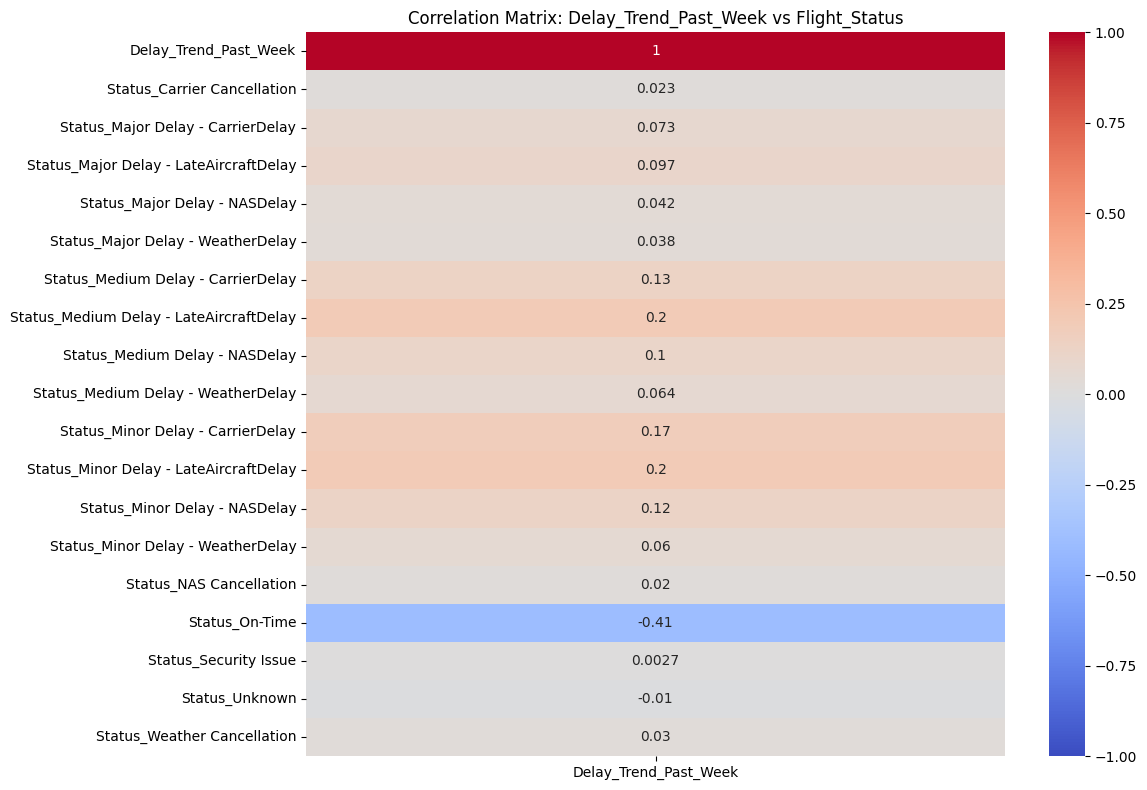

In [ ]:
trend = analyze_delay_trend_correlation(data)

One of the most valuable insights from our project came from examining the trend of delays on specific routes over time. To better understand this relationship, we analyzed how the average delay on a route over the past week was related to different types of flight outcomes.

The chart above shows how this weekly delay trend is associated with each flight status. Warmer colors (toward red) indicate a stronger positive connection, while cooler colors (toward blue) indicate a negative one.

The key takeaway is that **routes that had more delays in the previous week were more likely to experience further delays**, especially medium delays across categories like carrier issues and late aircraft. These values range from moderate (around 0.17 to 0.2) but are consistently positive for various delay types, showing a clear pattern.

On the other hand, **on-time flights showed a strong negative relationship**, meaning they are much less likely to appear on routes with recent delay history. This helps confirm that recent route performance is a reliable signal for future disruptions.

Even though the overall numbers may appear small, the trend is meaningful: past problems tend to repeat. By tracking how flights on a specific route have been performing recently, we’re able to provide useful early warnings for flights that may be at risk.

This supports the use of route-specific delay history as a core part of our delay prediction process.

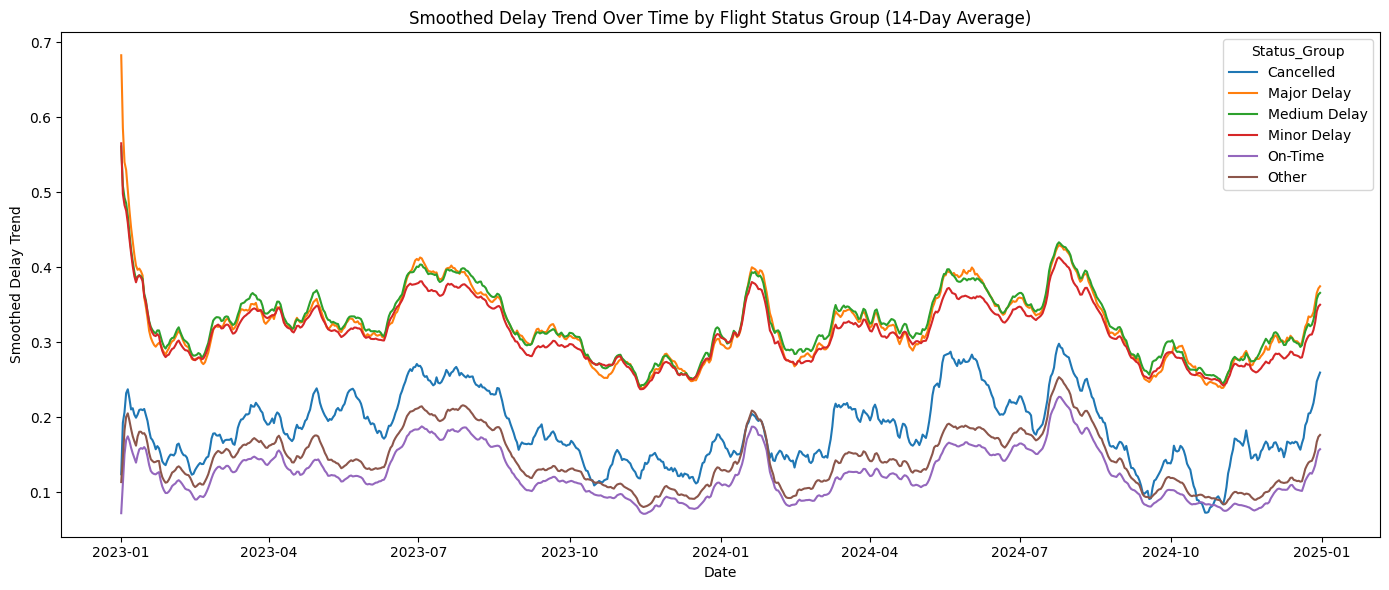

In [40]:
plot_smoothed_delay_trend(data)

- **Major, Medium, and Minor Delays** consistently show higher delay trend values over time, following similar seasonal patterns.
  
- **Cancelled flights** show notable spikes during periods of higher delays, particularly during seasonal peaks like winter and early summer.

- **On-Time flights** consistently show the lowest delay trends across all months, further validating that this feature is a strong signal for distinguishing flights that are likely to depart as scheduled.

- Seasonal effects are visible, with **delay trends rising during winter and mid-summer**, likely tied to weather challenges and high travel demand.

By looking at how delays build up over time on specific routes, we gain a powerful tool to forecast future disruptions. This rolling trend approach acts like an early warning system, if delays have been rising on a particular route over the past week, there’s a higher chance of more delays to come. For operations teams, this provides context for resource planning. Knowing when delay risk is rising and what types of outcomes are most likely to result allows for smarter scheduling, better communication, and proactive service adjustments.


## **Weather Data**

### **Snowfall's Impact**

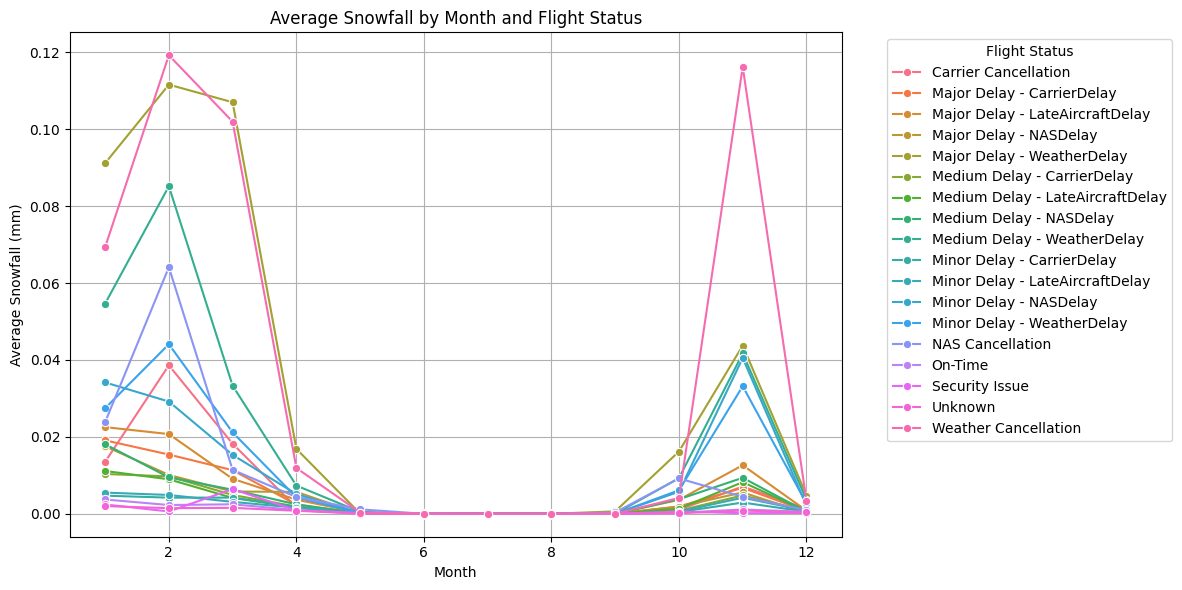

In [42]:
plot_avg_snowfall_by_status(data)

We looked at how snowfall affects flights throughout the year, and the results were clear. During the winter months, especially from **December to March**, snowfall levels are higher, and that’s when we also see a noticeable increase in delayed and cancelled flights due to weather.

Flights that were delayed or cancelled during this time typically experienced more snowfall than those that were on time. In contrast, during the spring and summer months, when snowfall is nearly nonexistent, weather-related delays are much less common.

This pattern tells us that snowfall plays a meaningful role in flight disruptions. By including snowfall in our prediction system, we give airlines a better chance to prepare for potential delays during the colder months, long before passengers even reach the airport.

### **Precipitation**


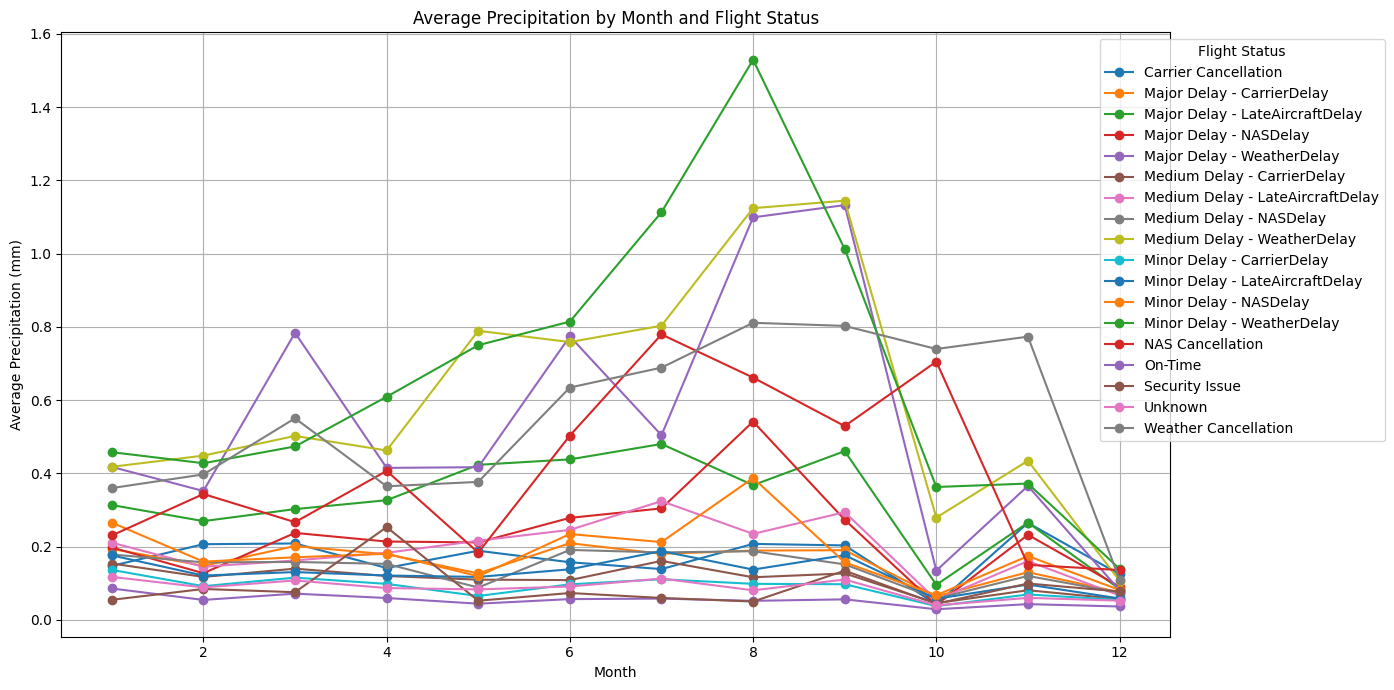

In [44]:
plot_avg_precipitation_by_status(data)

The graph above shows the average monthly precipitation levels across different flight statuses. The purpose of this chart is to understand how weather, particularly rainfall, correlates with flight delays and cancellations.

- **Mid to Late Summer Peaks**: The highest levels of precipitation are observed between June and September. This period overlaps with a noticeable increase in flight delays, particularly those related to weather and airspace traffic.
  
- **Weather Delay Link**: Categories like `Weather Delay` and `Weather Cancellation` are consistently higher in precipitation-heavy months.

- **On-Time Flights Stay Flat**: The line for `On-Time` flights remains relatively flat across the year, indicating that these flights tend to operate in more favorable conditions or on routes less affected by rain.

From this data, it becomes clear that precipitation should be taken seriously when planning ahead. Routes that are prone to high rainfall during these months should be flagged for closer monitoring. By knowing when and where precipitation is likely to increase, teams can proactively prepare. This may include assigning more buffer time between flights, prioritizing aircraft known to be less sensitive to weather delays, or offering passengers alternate travel options ahead of time.

### **Aircraft Data**
We explored aircraft-related details, such as model type and configuration, but didn’t find any meaningful or consistent patterns related to delays. Additionally, some aircraft-specific fields had too much missing or inconsistent data to be useful. As a result, we focused on more reliable features like aircraft age and flight schedule timing instead.

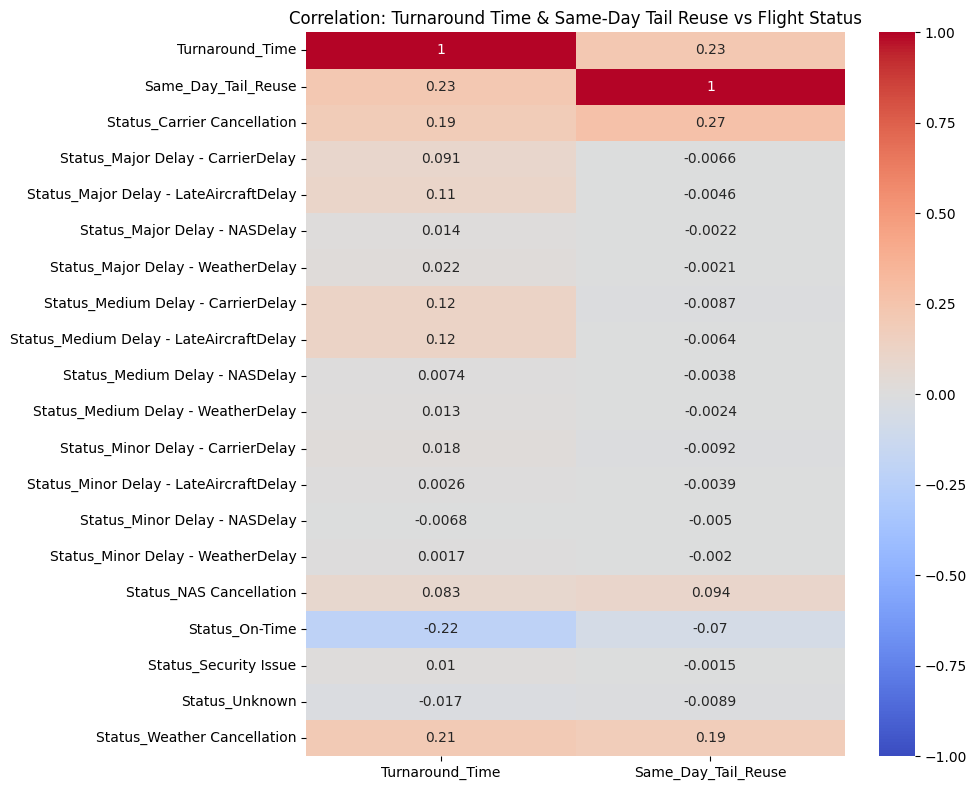

In [48]:
plot_turnaround_and_tail_reuse_correlation(data)

### **Turnaround Time and Aircraft Reuse**

We looked into how two scheduling factors contribute to flight delays and cancellations:

1. **Turnaround Time**: the gap between when a plane lands and when it's scheduled to depart again.
2. **Same-Day Aircraft Reuse**: how often the same plane is used for multiple flights in one day.

From the data, we found two important patterns:

- **Short Turnaround Time** is closely tied to delays. When planes are quickly scheduled for the next flight, there’s little room to recover from unexpected issues like late arrivals or slow boarding. This increases the chance of that next flight running late.
  
- **Heavily Reused Aircraft** when one plane handles too many flights in a single day, also shows a clear link to disruptions. If one flight is delayed, it often sets off a chain reaction for the rest of the day.

These findings suggest that tight scheduling comes at a cost. By identifying flights that are at risk due to these patterns, airlines can make simple adjustments like giving planes more time on the ground or avoiding overloading a single aircraft which helps avoid larger problems later on. In short, small changes in how flights are scheduled can lead to fewer delays, smoother operations, and a better experience for passengers.

## **Conclusion**

In conclusion, our models ended up not being very good. The scores for logistic regression and MLP which were the models that we tweaked the hyperparameters for were not good. 

We chose to use the MLP as our model to run on the test set. This is becasue on the train data, it had the best scores. This is mostly because of the class balancing that was done to fix the severe imbalance. 

The scores for the test set may be acceptable at first glance. We see that we have a test precision at recall 0.2 of 0.6249. On the surface this looks great but upon deeper inspection this is because it just picked on time for everything when fitting on the dataset because it had way more of that class to train on. If there was more time avaliable, I would look to see why the fix that I did on the training data did not apply to the test data. 